# Kaggle Housing Prices

> This is a Kaggle starter notebook for Predicting Housing Prices

- toc: true
- badges: true
- comments: true
- categories: [kaggle, starter]
- images: images/housing-prices.png

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from functools import partial
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
DATA_DIR = Path("/kaggle/input/house-prices-advanced-regression-techniques/")

train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")
sub_df = pd.read_csv(DATA_DIR / "sample_submission.csv")

In [ ]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Find Numerical and Categorical Columns
# Choose only columns that have at least 1000 non-null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## EDA

<AxesSubplot:>

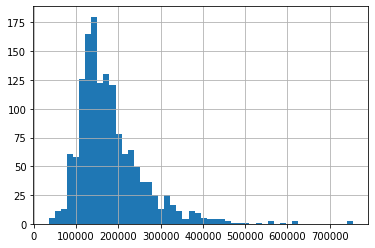

In [ ]:
# Most of the homes have sale price between 100-200K
train_df["SalePrice"].hist(bins=50)

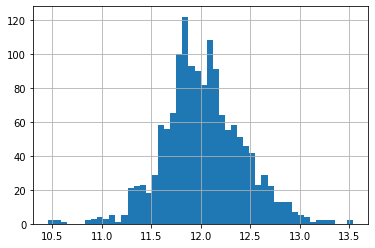

In [ ]:
# Converts LongTail to Normal Dist
# So We should convert target to Log, even if the Metric is not using it
np.log(train_df["SalePrice"]).hist(bins=50);

<AxesSubplot:xlabel='Id', ylabel='SalePrice'>

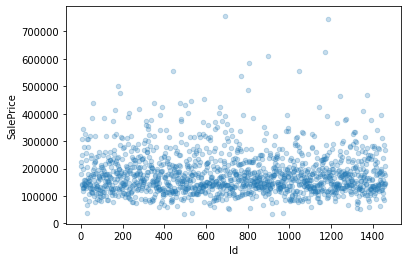

In [ ]:
# Observe that only two houses have over 700K Sale Price
# May be we should exclude them from dataset since there's no much we can gain from two data points
train_df.plot(kind="scatter", x="Id", y="SalePrice", alpha=0.25)

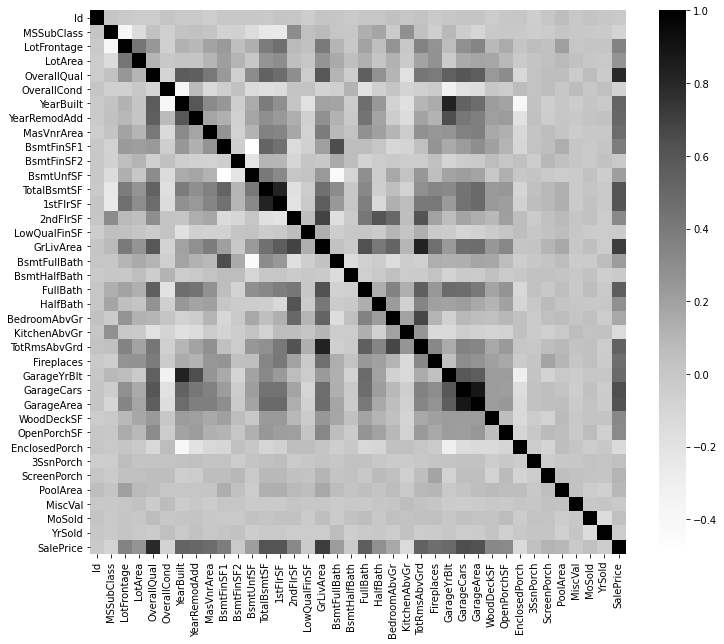

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), cmap='Greys');

In [ ]:
train_df.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [ ]:
corr_cols = train_df.corr()["SalePrice"].nlargest(15).index
corr_cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

<AxesSubplot:>

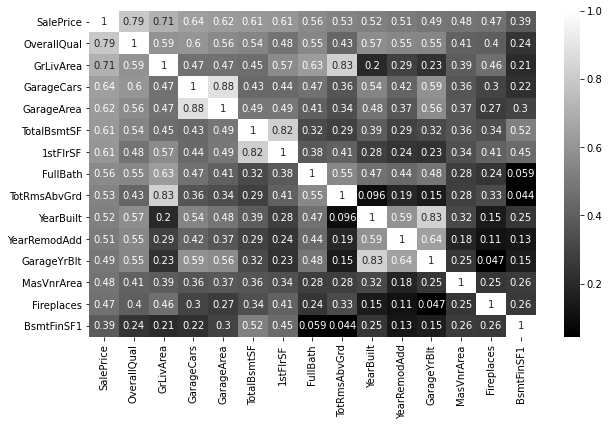

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.loc[:, corr_cols].corr(), annot=True, cmap="gray")

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

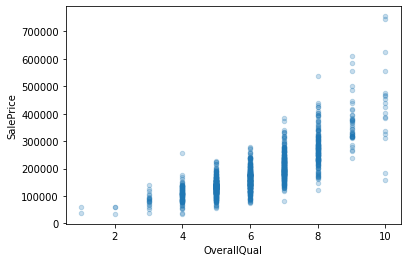

In [ ]:
## Lets look at ones with highest Correlation with SalePrice
# Overall Quality has big impact on SalePrice
train_df.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.25)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

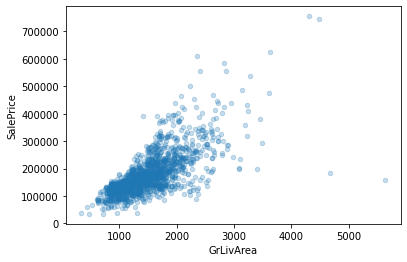

In [ ]:
## Lets look at ones with highest Correlation with SalePrice
# GrLivAera is also strongly correlated.  
# There are only four datapoints over 4K sqFeet. Should we include them?
train_df.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.25)

In [ ]:
train_df[train_df.GrLivArea > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

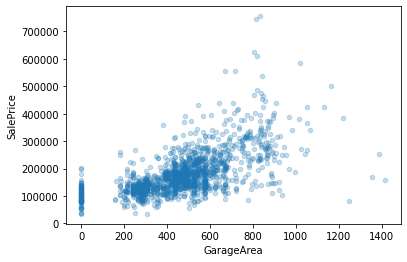

In [ ]:
## Lets look at ones with highest Correlation with SalePrice
# GrLivAera is also strongly correlated.  
# There are only four datapoints over 4K sqFeet. Should we include them?
train_df.plot(kind="scatter", x="GarageArea", y="SalePrice", alpha=0.25)

In [ ]:
train_df[train_df.GarageArea > 1200]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
# Exclude the two rows that are over 700k
train_df = train_df[train_df["SalePrice"] < 700000]

In [ ]:
# Automatic way to select all Categorical and Numeric Columns
def get_features(train_df):
    num_features, cat_features = [], []
    for col in train_df.columns:
        if col in ["Id", "SalePrice"]:
            continue
        dtype = train_df[col].dtype
        ratio = pd.notna(train_df[col]).sum() / len(train_df[col])
        if ratio < 0.5:
            continue
        if dtype == "object":
            cat_features.append(col)
        else:
            num_features.append(col)
    return num_features, cat_features

In [ ]:
num_features, cat_features = get_features(train_df)

In [ ]:
cat_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
def get_preprocess_pipeline(train_df, sample_features=False):
    # Get Numeric and Categorical Features
    numeric_features, categorical_features = get_features(train_df)
    target = "SalePrice"
    if sample_features:
        numeric_features = ["LotArea"]
        categorical_features = ["SaleType", "SaleCondition"]
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='N/A')),
        ('onehpt', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    return preprocessor, numeric_features + categorical_features, target

In [ ]:
def train_LR(train_df, test_df, sample_features=False):
    """
    Train a Linear Regression Model 
    """
    # Start with simple linear Model
    preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=sample_features)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LinearRegression())])
    X_train = train_df[features]
    y_train = np.log(train_df[target])
    X_test = test_df[features]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    
    clf.fit(X_train, y_train)
    print("RMSE Log Error", rmse(clf.predict(X_valid), y_valid))
    # On Prediction, do exp to inverse the loge done during training
    sub_df = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": np.exp(clf.predict(X_test))
    })
    return sub_df

In [ ]:
# Choose only a small sample of features.- 2-3 features to test the pipeline
sub_df = train_LR(train_df, test_df, sample_features=True)
sub_df.to_csv("submission_lr_sample.csv", index=False)
# Make a submission to Kaggle after downloading the submission file from right side (data -> output)

RMSE Log Error 0.3749878871754616


In [ ]:
# Lets improve the model, by giving it more features
sub_df = train_LR(train_df, test_df, sample_features=False)
sub_df.to_csv("submission_lr.csv", index=False)
# Make a submission to Kaggle after downloading the submission file from right side (data -> output)

RMSE Log Error 0.13212079796339762


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for p1, p2 in kfold.split(range(20)):
    print(p1, p2)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19] [ 0 17]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19] [ 1 15]
[ 0  1  2  3  4  6  7  9 10 11 12 13 14 15 16 17 18 19] [5 8]
[ 0  1  2  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19] [ 3 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19] [16 18]
[ 0  1  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [ 2 13]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18] [ 9 19]
[ 0  1  2  3  5  6  7  8  9 10 11 13 14 15 16 17 18 19] [ 4 12]
[ 0  1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 18 19] [ 7 10]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19] [ 6 14]


In [ ]:
kfold = KFold(n_splits=7, shuffle=True, random_state=42)
for idxs in kfold.split(train_df):
    print(idxs[0].shape, idxs[1].shape)

(1249,) (209,)
(1249,) (209,)
(1250,) (208,)
(1250,) (208,)
(1250,) (208,)
(1250,) (208,)
(1250,) (208,)


In [ ]:
idxs

(array([   0,    2,    3, ..., 1454, 1456, 1457]),
 array([   1,   13,   14,   20,   21,   34,   40,   64,   87,   91,   95,
          98,  112,  121,  122,  130,  134,  143,  161,  166,  187,  189,
         197,  200,  201,  202,  205,  206,  216,  219,  230,  241,  246,
         252,  269,  276,  279,  288,  293,  295,  315,  317,  330,  337,
         343,  378,  379,  384,  385,  387,  391,  392,  397,  400,  401,
         406,  418,  441,  455,  459,  466,  474,  484,  492,  502,  508,
         510,  520,  524,  540,  556,  562,  563,  564,  565,  577,  592,
         600,  608,  612,  627,  632,  641,  642,  645,  646,  647,  648,
         663,  681,  683,  686,  698,  699,  702,  709,  719,  725,  729,
         742,  747,  748,  751,  763,  766,  769,  775,  776,  779,  791,
         794,  795,  804,  805,  815,  831,  835,  840,  854,  856,  860,
         863,  870,  871,  878,  883,  891,  897,  929,  951,  955,  957,
         960,  972,  975,  981,  995, 1012, 1016, 1017, 1020,

In [ ]:
def hyperparam_finder_nocv(df, model_fn, trial):
    """
    Hyperparameter Finder
    """
    # Start with simple linear Model
    model = model_fn(trial)
    preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=False)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    X_train = train_df[features]
    y_train = np.log(train_df[target])
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    
    clf.fit(X_train, y_train)
    return rmse(clf.predict(X_valid), y_valid)

In [ ]:
def hyperparam_finder(df, model_fn, trial):
    """
    Hyperparameter Finder
    """
    # Start with simple linear Model
    model = model_fn(trial)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    valid_errors = []
    test_preds = []
    valid_preds = []
    for train_idxs, valid_idxs in kfold.split(df):
        train_df = df.iloc[train_idxs]
        valid_df = df.iloc[valid_idxs]

        preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=False)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        X_train = train_df[features]
        y_train = np.log(train_df[target])
        X_valid = valid_df[features]
        y_valid = np.log(valid_df[target])
        X_test = test_df[features]
        clf.fit(X_train, y_train)
        y_valid_preds = clf.predict(X_valid)
        valid_errors.append(rmse(y_valid_preds, y_valid))
    # Return Valid Pred Score for HyperParam Tuning
    return np.mean(valid_errors)

In [ ]:
# You would have seen an improvement on your Leaderboard by providing it better features
# Now lets do KFold (5 Fold)
def train_kfold(df, test_df, ModelClass, **model_kwargs):
    """
    Train a Regression Model with 5 Fold CV
    """
    # Start with simple linear Model
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    valid_errors = []
    test_preds = []
    valid_preds = []
    for train_idxs, valid_idxs in kfold.split(df):
        train_df = df.iloc[train_idxs]
        valid_df = df.iloc[valid_idxs]

        preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=False)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ModelClass(**model_kwargs))])
        X_train = train_df[features]
        y_train = np.log(train_df[target])
        X_valid = valid_df[features]
        y_valid = np.log(valid_df[target])
        X_test = test_df[features]
        clf.fit(X_train, y_train)
        y_valid_preds = clf.predict(X_valid)
        valid_errors.append(rmse(y_valid_preds, y_valid))
        test_preds.append(np.exp(clf.predict(X_test)))
        valid_preds.append(pd.DataFrame({
            "Id": valid_df["Id"],
            "SalePrice": np.exp(y_valid_preds)
        }))

    print("RMSE Log Error", np.mean(valid_errors))
    # On Prediction, do exp to inverse the loge done during training
    sub_df = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": np.mean(test_preds, axis=0)
    })
    # Return test prediction with CV and the Validation Prediction (For Stacking later)
    return sub_df, pd.concat(valid_preds)

In [ ]:
# Lets improve the model by choosing XGBoost over Linear Classifier
model1_sub_df, model1_valid_preds = train_kfold(train_df, test_df, LinearRegression)
sub_df.to_csv("submission_lr_kfold.csv", index=False)
# Make a submission to Kaggle after downloading the submission file from right side (data -> output)
# Score might have improved over the LR without kfold.

RMSE Log Error 0.15228419074391034


In [ ]:
def train_XGB_kfold(df, test_df):
    """
    Train a XGBoost Model with 5 Fold CV
    """
    # Start with simple linear Model
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    valid_errors = []
    test_preds = []
    valid_preds = []
    for train_idxs, valid_idxs in kfold.split(df.index.values):
        train_df = df.loc[train_idxs]
        valid_df = df.loc[valid_idxs]

        preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=False)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', XGBRegressor(n_jobs=-1, n_estimators=500, max_depth=20))])
        X_train = train_df[features]
        y_train = np.log(train_df[target])
        X_valid = valid_df[features]
        y_valid = np.log(valid_df[target])
        X_test = test_df[features]
        clf.fit(X_train, y_train)
        y_valid_preds = clf.predict(X_valid)
        valid_errors.append(rmse(y_valid_preds, y_valid))
        test_preds.append(np.exp(clf.predict(X_test)))
        valid_preds.append(pd.DataFrame({
            "Id": valid_df["Id"],
            "SalePrice": np.exp(y_valid_preds)
        }))

    print("Mean Squared Log Error", np.mean(valid_errors))
    # On Prediction, do exp to inverse the loge done during training
    sub_df = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": np.mean(test_preds, axis=0)
    })
    # Return test prediction with CV and the Validation Prediction (For Stacking later)
    return sub_df, pd.concat(valid_preds)

def train_RF_kfold(df, test_df):
    """
    Train a RF Model with 5 Fold CV
    """
    # Start with simple linear Model
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    valid_errors = []
    test_preds = []
    valid_preds = []
    for train_idxs, valid_idxs in kfold.split(df.index.values):
        train_df = df.loc[train_idxs]
        valid_df = df.loc[valid_idxs]

        preprocessor, features, target = get_preprocess_pipeline(train_df, sample_features=False)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestRegressor(n_jobs=-1, max_depth=20))])
        X_train = train_df[features]
        y_train = np.log(train_df[target])
        X_valid = valid_df[features]
        y_valid = np.log(valid_df[target])
        X_test = test_df[features]
        clf.fit(X_train, y_train)
        y_valid_preds = clf.predict(X_valid)
        valid_errors.append(mean_squared_error(y_valid_preds, y_valid))
        test_preds.append(np.exp(clf.predict(X_test)))
        valid_preds.append(pd.DataFrame({
            "Id": valid_df["Id"],
            "SalePrice": np.exp(y_valid_preds)
        }))

    print("Mean Squared Log Error", np.mean(valid_errors))
    # On Prediction, do exp to inverse the loge done during training
    sub_df = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": np.mean(test_preds, axis=0)
    })
    # Return test prediction with CV and the Validation Prediction (For Stacking later)
    return sub_df, pd.concat(valid_preds)

In [ ]:
Ridge()

In [ ]:
def lasso_hparams_finder(trial):
    alpha = trial.suggest_float("alpha", 0, 1.0)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return Lasso(alpha=alpha, max_iter=max_iter)

def ridge_hparams_finder(trial):
    alpha = trial.suggest_float("alpha", 0, 1.0)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return Ridge(alpha=alpha, max_iter=max_iter)

def xgb_hparams_finder(trial):
    max_depth = trial.suggest_int("max_depth", 5, 30)
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    tree_method = trial.suggest_categorical("tree_method", ["gpu_hist"])
    gamma = trial.suggest_float("gamma", 0, 1)
    eta = trial.suggest_float("eta", 0, 1)
    return XGBRegressor(
        max_depth=max_depth, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        tree_method=tree_method, 
        gamma=gamma, 
        eta=eta
    )

def rf_hparams_finder(trial):
    max_depth = trial.suggest_int("max_depth", 10, 50)
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    return RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

def lightgbm_hparams_finder(trial):
    max_depth = trial.suggest_int("max_depth", 5, 30)
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 0., 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0., 1)
    return LGBMRegressor(max_depth=max_depth, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

def svr_hparams_finder(trial):
    kernel = trial.suggest_categorical("kernel", 
                                          ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
    degree = trial.suggest_int("degree", 1, 4)
    c = trial.suggest_float("c", 0, 1)
    max_iter = trial.suggest_float("max_iter", 50, 500)
    return SVR(kernel=kernel, degree=degree, C=c, max_iterm=max_iter)

In [ ]:
# Lets improve the model by choosing XGBoost over Linear Classifier
optuna.create_study()
study = optuna.create_study()
study.optimize(partial(hyperparam_finder, train_df, lasso_hparams_finder), 
               n_trials=100, 
               show_progress_bar=True
              )
lasso_params = study.best_params  # E.g. {'x': 2.002108042}

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Lets improve the model by choosing XGBoost over Linear Classifier
model_options = {
        "ridge": ridge_hparams_finder,
        "lasso": lasso_hparams_finder,
        "xgb": xgb_hparams_finder,
        "rf": rf_hparams_finder,
        "ligtgbm": lightgbm_hparams_finder,
        "svr": svr_hparams_finder
    }
best_hparams = []
for model_name, model_hparams_fn in model_options.items():
    print(model_name)
    optuna.create_study()
    study = optuna.create_study()
    study.optimize(partial(hyperparam_finder_nocv, train_df, model_hparams_fn), 
                   n_trials=20, 
                   show_progress_bar=True
                  )

    best_hparams.append({
        model_name: study.best_params
    })

ridge


/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

lasso


/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

xgb


/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Lets improve the model by choosing XGBoost over Linear Classifier
optuna.create_study()
study = optuna.create_study()
study.optimize(partial(hyperparam_finder, train_df, lasso_hparams_finder), 
               n_trials=100, 
               show_progress_bar=True
              )
lasso_params = study.best_params  # E.g. {'x': 2.002108042}

In [ ]:
# Lets improve the model by choosing XGBoost over Linear Classifier
model1_test_preds, model1_valid_preds = train_kfold(train_df, test_df, Ridge)

# Lets improve the model by choosing XGBoost over Linear Classifier
model2_test_preds, model2_valid_preds = train_kfold(train_df, test_df,  XGBRegressor, n_jobs=4, n_estimators=500, max_depth=20)

# Lets improve the model by choosing RF over Linear Classifier
model3_test_preds, model3_valid_preds = train_kfold(train_df, test_df, RandomForestRegressor,n_jobs=4, n_estimators=500, max_depth=20)

# Lets improve the model by choosing SVR
model4_test_preds, model4_valid_preds = train_kfold(train_df, test_df,  SVR)

# Lets improve the model by choosing  LightGBM
model5_test_preds, model5_valid_preds = train_kfold(train_df, test_df,  LGBMRegressor, n_jobs=4, n_estimators=500, max_depth=20)

RMSE Log Error 0.14397705141849326
RMSE Log Error 0.14641944560849735
RMSE Log Error 0.14289517901441579
RMSE Log Error 0.13849838128051936
RMSE Log Error 0.12958699005124785


In [ ]:
model1_valid_preds.rename(columns={"SalePrice": "model1_preds"}, inplace=True)
model2_valid_preds.rename(columns={"SalePrice": "model2_preds"}, inplace=True)
model3_valid_preds.rename(columns={"SalePrice": "model3_preds"}, inplace=True)
model4_valid_preds.rename(columns={"SalePrice": "model4_preds"}, inplace=True)
model5_valid_preds.rename(columns={"SalePrice": "model5_preds"}, inplace=True)

In [ ]:
model1_test_preds.rename(columns={"SalePrice": "model1_preds"}, inplace=True)
model2_test_preds.rename(columns={"SalePrice": "model2_preds"}, inplace=True)
model3_test_preds.rename(columns={"SalePrice": "model3_preds"}, inplace=True)
model4_test_preds.rename(columns={"SalePrice": "model4_preds"}, inplace=True)
model5_test_preds.rename(columns={"SalePrice": "model5_preds"}, inplace=True)

In [ ]:
pd.merge(model1_test_preds, model2_test_preds, left_on="Id", right_on="Id")

,Id,model1_preds,model2_preds
0,1461,117713.829211,124097.960938
1,1462,146528.150506,162885.296875
2,1463,177353.856048,179494.609375
3,1464,197262.388246,189156.562500
4,1465,198261.170350,191763.968750
...,...,...,...
1454,2915,82789.895485,82117.929688
1455,2916,84069.656304,83893.187500
1456,2917,163975.093345,169720.000000
1457,2918,113470.524225,113896.640625


In [ ]:
# Model Blending - Take the Average of the three Model Predictions
sub_df = pd.merge(model1_test_preds, model2_test_preds, left_on="Id", right_on="Id")
sub_df = pd.merge(sub_df, model3_test_preds, left_on="Id", right_on="Id")
sub_df = pd.merge(sub_df, model4_test_preds, left_on="Id", right_on="Id")
sub_df = pd.merge(sub_df, model5_test_preds, left_on="Id", right_on="Id")
sub_df["SalePrice"] = (sub_df["model1_preds"] + sub_df["model2_preds"] + sub_df["model3_preds"] + sub_df["model4_preds"] + sub_df["model5_preds"])/5
sub_df[["Id", "SalePrice"]].to_csv("submission_model_blend.csv", index=False)

In [ ]:
# You would have seen an improvement on your Leaderboard with KFold.
# Now Lets do Model Stacking.
# Choose three Models - LinearRegression, RandomForest and XGBoost and get Predictions
# Average ALL three Predictions (With KFold) and make a Submission.  This will give you Model Blending
# TODO

In [ ]:
layer1_test_df = pd.merge(model1_test_preds, model2_test_preds, left_on="Id", right_on="Id")
layer1_test_df = pd.merge(layer1_test_df, model3_test_preds, left_on="Id", right_on="Id")
layer1_test_df = pd.merge(layer1_test_df, model4_test_preds, left_on="Id", right_on="Id")
layer1_test_df = pd.merge(layer1_test_df, model5_test_preds, left_on="Id", right_on="Id")

layer1_test_df.head()

,Id,model1_preds,model2_preds,model3_preds,model4_preds,model5_preds
0,1461,117713.829211,124097.960938,126180.720900,119344.635252,125128.727896
1,1462,146528.150506,162885.296875,153965.312504,182667.415871,150943.897192
2,1463,177353.856048,179494.609375,177589.522503,180658.023391,187343.404402
3,1464,197262.388246,189156.562500,182245.150263,194350.575145,185932.924479
4,1465,198261.170350,191763.968750,196898.030631,189742.998719,184235.322421


In [ ]:
layer1_train_df = pd.merge(model1_valid_preds, model2_valid_preds, left_on="Id", right_on="Id")
layer1_train_df = pd.merge(layer1_train_df, model3_valid_preds, left_on="Id", right_on="Id")
layer1_train_df = pd.merge(layer1_train_df, model4_valid_preds, left_on="Id", right_on="Id")
layer1_train_df = pd.merge(layer1_train_df, model5_valid_preds, left_on="Id", right_on="Id")

layer1_train_df = pd.merge(layer1_train_df, train_df[["Id", "SalePrice"]], left_on="Id", right_on="Id")
layer1_train_df.head()

,Id,model1_preds,model2_preds,model3_preds,model4_preds,model5_preds,SalePrice
0,16,139940.327034,133994.156250,156806.829127,134248.224855,151408.259753,132000
1,24,132404.159793,143172.593750,140933.363142,143026.241725,133380.441989,129900
2,30,78196.145620,72757.703125,74290.411810,77943.702050,75490.226312,68500
3,31,65289.900643,85316.335938,95203.013404,85049.653410,92450.252907,40000
4,33,201075.364368,195446.609375,206302.013767,182591.810407,188616.393510,179900


In [ ]:
# Finally try Model Stacking (Hint: Using the Validation Predictions you obtained from the CV Models to train a new Model for Prediction)
# You would have seen an improvement on your Leaderboard by providing it better features
# Now lets do KFold (5 Fold)
def train_model_stacking_kfold(df, test_df):
    """
    Train a Linear Regression Model with 5 Fold CV
    """
    # Start with simple linear Model
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    valid_errors = []
    test_preds = []
    features = ["model1_preds", "model2_preds", "model3_preds", "model4_preds", "model5_preds"]
    df = df.copy()
    test_df = test_df.copy()
    for feat in features:
        df[feat] = np.log(df[feat])
        test_df[feat] = np.log(test_df[feat])
    df["SalePrice"] = np.log(df["SalePrice"])
    for train_idxs, valid_idxs in kfold.split(df):
        train_df = df.loc[train_idxs]
        valid_df = df.loc[valid_idxs]
        X_train = train_df[features]
        y_train = train_df["SalePrice"]
        X_valid = valid_df[features]
        y_valid = valid_df["SalePrice"]
        X_test = test_df[features]
        clf = LinearRegression()
        clf.fit(X_train, y_train)
        y_valid_preds = clf.predict(X_valid)
        valid_errors.append(rmse(y_valid_preds, y_valid))
        test_preds.append(np.exp(clf.predict(X_test)))

    print("RMSE Log Error", np.mean(valid_errors))
    # On Prediction, do exp to inverse the loge done during training
    sub_df = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": np.mean(test_preds, axis=0)
    })
    # Return test prediction with CV
    return sub_df

In [ ]:
sub_df = train_model_stacking_kfold(layer1_train_df, layer1_test_df)
sub_df[["Id", "SalePrice"]].to_csv("submission_model_stack.csv", index=False)

RMSE Log Error 0.12191138856220185


In [ ]:
import lightgbm